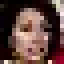

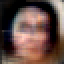

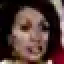

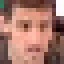

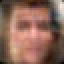

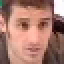

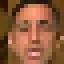

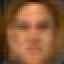

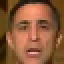

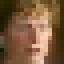

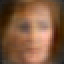

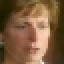

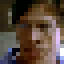

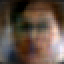

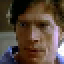

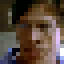

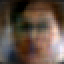

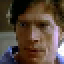

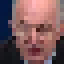

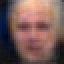

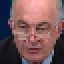

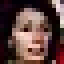

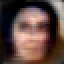

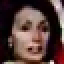

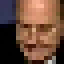

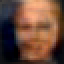

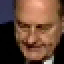

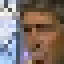

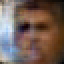

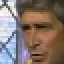

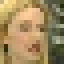

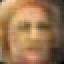

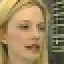

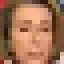

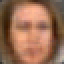

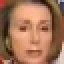

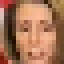

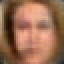

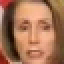

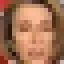

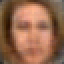

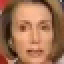

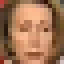

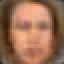

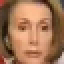

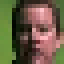

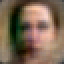

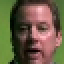

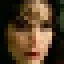

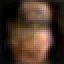

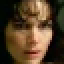

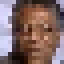

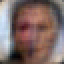

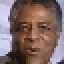

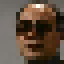

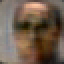

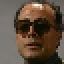

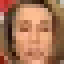

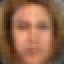

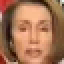

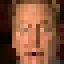

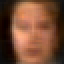

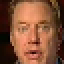

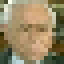

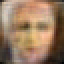

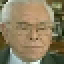

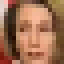

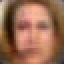

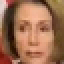

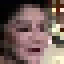

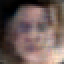

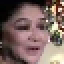

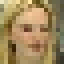

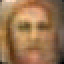

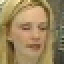

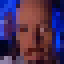

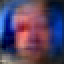

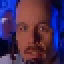

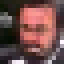

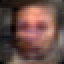

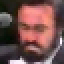

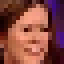

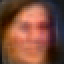

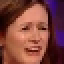

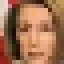

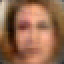

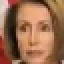

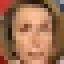

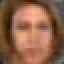

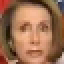

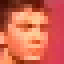

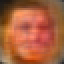

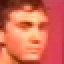

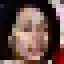

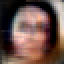

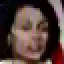


validation error is 0.0668	


In [6]:
image = require 'image'
require 'nn'

opt = {
    outchan = 3,
    inchan = 3,
    num_frames = 3,
    num_epoch = 10000,
    batchsize = 128,
    valSize = 32,
    gpu = false
}

valvidnames = torch.load('valvidnames.t7')
valimgs = torch.load('valimgs.t7')
vallabels = torch.load('vallabels.t7')

-- generate smaller validation set with previous and subsequent frames
valinputs = torch.FloatTensor(opt.valSize, opt.num_frames * opt.inchan, 16, 16)
valtruths = torch.FloatTensor(opt.valSize, opt.inchan, 32, 32)

for vi = 1, opt.valSize do
    local rand_id = torch.random(2, valimgs:size(1) - 1)
    while not (valvidnames[rand_id] == valvidnames[rand_id - 1] and valvidnames[rand_id] == valvidnames[rand_id + 1]) do
        rand_id = torch.random(2, valimgs:size(1) - 1)
    end
    valinputs[vi] = torch.cat(valimgs[rand_id - 1], valimgs[rand_id], 1):cat(valimgs[rand_id + 1], 1)
    valtruths[vi] = vallabels[rand_id]
end
-- for vi = 1, 4 do
--     itorch.image(valinputs[vi])
--     itorch.image(valtruths[vi])
-- end

gen = torch.load('srez_model_video_16_to_32.t7')
outputs = gen:forward(valinputs)
criterion = nn.AbsCriterion()

for vi = 1, opt.valSize do
    itorch.image(image.scale(valinputs[{vi, {4,6}, {}, {}}], 64, 64, 'simple'))
    itorch.image(image.scale(outputs[vi], 64, 64, 'simple'))
    itorch.image(image.scale(valtruths[vi], 64, 64, 'simple'))
end
valerr = criterion:forward(outputs, valtruths)
print(('\nvalidation error is %.4f'):format(valerr))
